# Imports

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

print("numpy version:" + np.__version__)
print("matplotlib version:" + mpl.__version__)

numpy version:1.19.2
matplotlib version:3.4.3


In [2]:
# Import example implementation for a circle-fit. Here we use the
# circle-fit of the qkit measurement framework available at
# https://github.com/qkitgroup/qkit. We import a local copy of the file
# qkit/qkit/analysis/circle_fit/circle_fit_2019/circuit.py at the
# commit 45d6ae9.
#
# We emphasize that any fitting procedure, which can extract the
# total line width, normalize the data to the measured off-resonant
# response and extract the center-point or (complex) radius of the
# normalized circle can be used here instead.

from circuit import reflection_port as circle_fit

In [3]:
preamble = "".join([
    r"\usepackage{siunitx}",
    r"\usepackage{amsmath}",
    r"\usepackage{lmodern}",
])

mpl.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": preamble,
        "font.size": 9,
        "font.family": "serif",
        "axes.titlesize": 9,
        "axes.labelsize": 9,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "figure.dpi": 200,
        "savefig.dpi": 300,
        "savefig.pad_inches": 0.01,
        "lines.linewidth": 1,
        "lines.markersize": 1,
    }
)

# Function and Variable Definitions

In [4]:
def plot_IQplane(xylim=1.1):
    """
    Sets up a complex plane plot to have equal axis scaling,
    useful axis labels, guiding lines through the origin and
    a  unit circle for orientation
    """
    
    plt.xlim(-xylim, xylim)
    plt.ylim(-xylim, xylim)
    plt.gca().set_aspect("equal")
    
    plt.xlabel(r"$\mathrm{Re}\,S_{11}$")
    plt.ylabel(r"$\mathrm{Im}\,S_{11}$", labelpad=-3)
    
    plt.axhline(0, c="k", lw=0.5, zorder=-1)
    plt.axvline(0, c="k", lw=0.5, zorder=-1)
    plt.gca().add_artist(Circle((0,0), 1, fill=False, ec="gray", lw=0.5))

# "Minimal" Working Example for Circle Fit with Fano

## Load and plot data

In [5]:
path = "Data/overcoupled/resonator_1_powersweep_overcoupled.npz"

with np.load(path) as data:
    frs = data["frequency"]
    amps = data["amplitude"]
    phases = data["phase"]
    powers = data["power"]
    
# Complex scattering data
zs = amps*np.exp(1j*phases)

# zs, amps and phases are arrays of shape (len(powers) = 29, len(frs) = 1001)
print(zs.shape)

# Select certain power to plot and analyze single trace
i_power = 0
zs = zs[i_power]

(29, 1001)


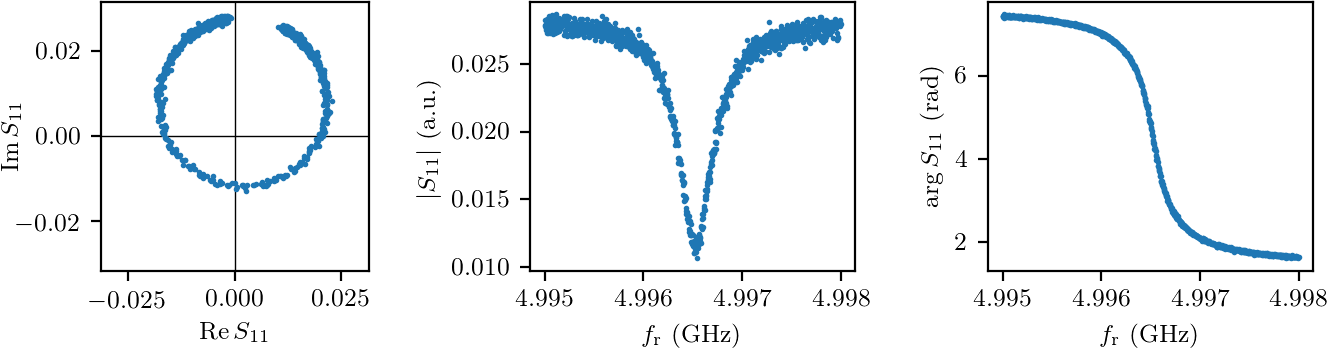

In [6]:
# Plot the raw, measured scattering data
plt.figure(figsize=(7, 2))

# Circle data
plt.subplot(131)
plot_IQplane(xylim=np.max(np.abs(zs))*1.1)
plt.plot(zs.real, zs.imag, "o")

# Amplitude response
plt.subplot(132)
plt.plot(frs/1e9, np.abs(zs), "o")
plt.xlabel(r"$f_\mathrm{r}$ (GHz)")
plt.ylabel(r"$|S_{11}|$ (a.u.)")

# Phase response
plt.subplot(133)
plt.plot(frs/1e9, np.unwrap(np.angle(zs)) + 2*np.pi, "o")
plt.xlabel(r"$f_\mathrm{r}$ (GHz)")
plt.ylabel(r"$\arg S_{11}$ (rad)")

plt.tight_layout()

## Do circle fit and plot again

In [7]:
# Use 15 dB isolation of the background path as example
# (this is the default value)
cf = circle_fit(frs, zs)
cf.autofit(isolation=15)

# Internally this performs:

# cf._calibrate()
# cf._normalize()
# cf._extract_Qs()
# cf.calc_fano_range(isolation=isolation)

print("fr (GHz): {:.4f}".format(cf.fitresults["fr"]/1e9))
print("Ql: {:.0f}".format(cf.fitresults["Ql"]))
print("kappa/2pi (MHz): {:.3f}".format(cf.fitresults["fr"]/cf.fitresults["Ql"]/1e6))
print()
print("Qi_min: {:.0f}".format(cf.fitresults["Qi_min"]))
print("Qi_mid: {:.0f}".format(cf.fitresults["Qi"]))
print("Qi_max: {:.0f}".format(cf.fitresults["Qi_max"]))
print()
print("Qc_min: {:.0f}".format(cf.fitresults["Qc_min"]))
print("Qc_mid: {:.0f}".format(cf.fitresults["Qc"]))
print("Qc_max: {:.0f}".format(cf.fitresults["Qc_max"]))

fr (GHz): 4.9965
Ql: 9749
kappa/2pi (MHz): 0.513

Qi_min: 21768
Qi_mid: 32930
Qi_max: 67587

Qc_min: 11392
Qc_mid: 13848
Qc_max: 17655


In [8]:
# Show manually how the quality factors are calculated in the method
# cf.calc_fano_range(isolation=15)

# Fix the value for the upper bound b corresponding to 15 dB isolation
b = 10**(-15/20)
b = b / (1 - b) # b_tilde of Eq. 9, but we keep b as a short variable name

# Length |R| of the (complex) radius R, i.e. length from (1,0) to center point
R_abs = cf.r0 
# Complex valued radius of the circle as defined by R' in Fig. 3 and Eq. 11
# in the manuscript. Note that cf.phi here refers to the nomenclature of
# Probst et al. (https://doi.org/10.1063/1.4907935), i.e. the tilt of the circle
# and would correspond to beta in our manuscript.
R = R_abs*np.exp(1j*cf.phi)
# Center point M' of the circle as defined in Fig. 3 and Eq. 11
zc = 1 - R

# Fano uncertainty procedure
R_mid = R.real
R_err = np.sqrt((b*R_abs)**2 - R.imag**2)
R_min = R_mid - R_err
R_max = R_mid + R_err

# Calculate the quality factors from Ql and R_min,mid,max
Qi_min = cf.Ql / (1 - R_min)
Qi_mid = cf.Ql / (1 - R_mid)
Qi_max = cf.Ql / (1 - R_max)
Qc_min = cf.Ql / R_max
Qc_mid = cf.Ql / R_mid
Qc_max = cf.Ql / R_min

# Handle "unphysical" R_max
if R_max >= 1:
    Qi_max = np.inf

# These values are equivalent to the ones calculated in the
# circle-fit class (see above)
print("Qi_min: {:.0f}".format(Qi_min))
print("Qi_mid: {:.0f}".format(Qi_mid))
print("Qi_max: {:.0f}".format(Qi_max))
print()
print("Qc_min: {:.0f}".format(Qc_min))
print("Qc_mid: {:.0f}".format(Qc_mid))
print("Qc_max: {:.0f}".format(Qc_max))

Qi_min: 21768
Qi_mid: 32930
Qi_max: 67587

Qc_min: 11392
Qc_mid: 13848
Qc_max: 17655


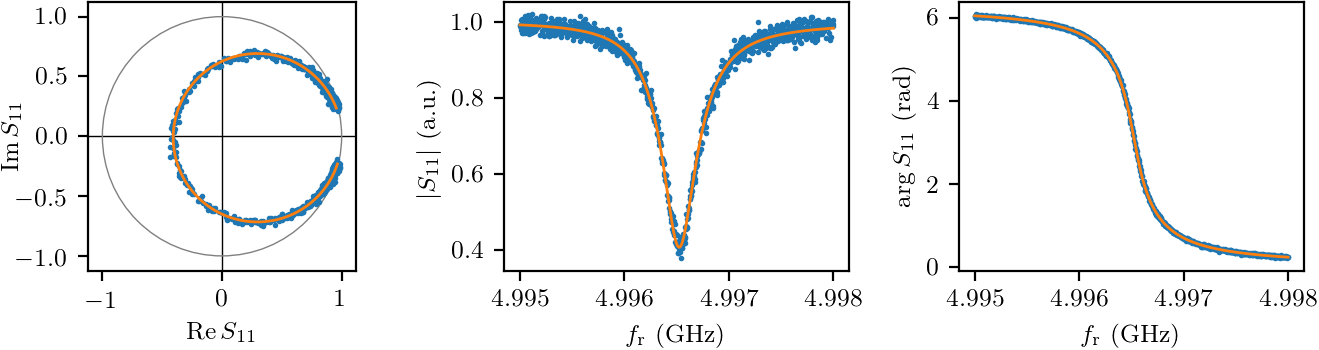

In [9]:
# Plot the normalized data and fit
plt.figure(figsize=(7, 2))

# Circle data
plt.subplot(131)
plot_IQplane(xylim=np.max(np.abs(cf.z_data_norm))*1.1)
plt.plot(cf.z_data_norm.real, cf.z_data_norm.imag, "o")
plt.plot(cf.z_data_sim_norm.real, cf.z_data_sim_norm.imag)

# Amplitude response
plt.subplot(132)
plt.plot(frs/1e9, np.abs(cf.z_data_norm), "o")
plt.plot(frs/1e9, np.abs(cf.z_data_sim_norm))
plt.xlabel(r"$f_\mathrm{r}$ (GHz)")
plt.ylabel(r"$|S_{11}|$ (a.u.)")

# Phase response
plt.subplot(133)
plt.plot(frs/1e9, np.unwrap(np.angle(cf.z_data_norm)) + 2*np.pi, "o")
plt.plot(frs/1e9, np.unwrap(np.angle(cf.z_data_sim_norm)) + 2*np.pi)
plt.xlabel(r"$f_\mathrm{r}$ (GHz)")
plt.ylabel(r"$\arg S_{11}$ (rad)")

plt.tight_layout()

## Repeat circle fit for an undercoupled resonator

In [10]:
path = "Data/undercoupled/resonator_1_powersweep_undercoupled.npz"

with np.load(path) as data:
    frs = data["frequency"]
    amps = data["amplitude"]
    phases = data["phase"]
    powers = data["power"]
    
# Complex scattering data
zs = amps*np.exp(1j*phases)

# zs, amps and phases are arrays of shape (len(powers) = 19, len(frs) = 1001)
print(zs.shape)

# Select certain power to plot and analyze single trace
i_power = 0
zs = zs[i_power]

(19, 1001)


In [11]:
# Note how the systematic uncertainty for Qi is much lower than
# in the overcoupled case but the uncertainty for Qc is higher

cf = circle_fit(frs, zs)
cf.autofit()  # uses default isolation=15

print("fr (GHz): {:.4f}".format(cf.fitresults["fr"]/1e9))
print("Ql: {:.0f}".format(cf.fitresults["Ql"]))
print("kappa/2pi (MHz): {:.3f}".format(cf.fitresults["fr"]/cf.fitresults["Ql"]/1e6))
print()
print("Qi_min: {:.0f}".format(cf.fitresults["Qi_min"]))
print("Qi_mid: {:.0f}".format(cf.fitresults["Qi"]))
print("Qi_max: {:.0f}".format(cf.fitresults["Qi_max"]))
print()
print("Qc_min: {:.0f}".format(cf.fitresults["Qc_min"]))
print("Qc_mid: {:.0f}".format(cf.fitresults["Qc"]))
print("Qc_max: {:.0f}".format(cf.fitresults["Qc_max"]))

fr (GHz): 5.0030
Ql: 56385
kappa/2pi (MHz): 0.089

Qi_min: 71322
Qi_mid: 76920
Qi_max: 83472

Qc_min: 173760
Qc_mid: 211210
Qc_max: 269238


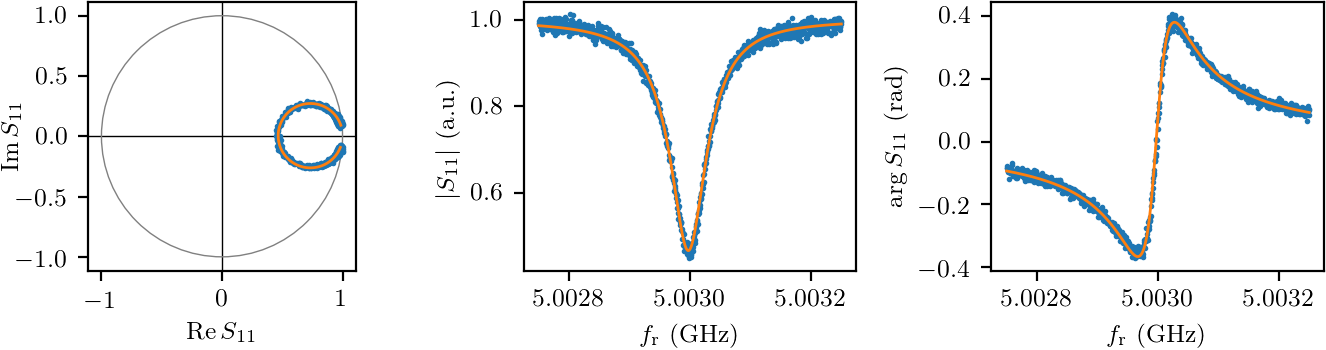

In [12]:
# Plot the normalized data and fit
plt.figure(figsize=(7, 2))

# Circle data
plt.subplot(131)
plot_IQplane(xylim=np.max(np.abs(cf.z_data_norm))*1.1)
plt.plot(cf.z_data_norm.real, cf.z_data_norm.imag, "o")
plt.plot(cf.z_data_sim_norm.real, cf.z_data_sim_norm.imag)

# Amplitude response
plt.subplot(132)
plt.plot(frs/1e9, np.abs(cf.z_data_norm), "o")
plt.plot(frs/1e9, np.abs(cf.z_data_sim_norm))
plt.xlabel(r"$f_\mathrm{r}$ (GHz)")
plt.ylabel(r"$|S_{11}|$ (a.u.)")

# Phase response
plt.subplot(133)
plt.plot(frs/1e9, np.unwrap(np.angle(cf.z_data_norm)), "o")
plt.plot(frs/1e9, np.unwrap(np.angle(cf.z_data_sim_norm)))
plt.xlabel(r"$f_\mathrm{r}$ (GHz)")
plt.ylabel(r"$\arg S_{11}$ (rad)")

plt.tight_layout()